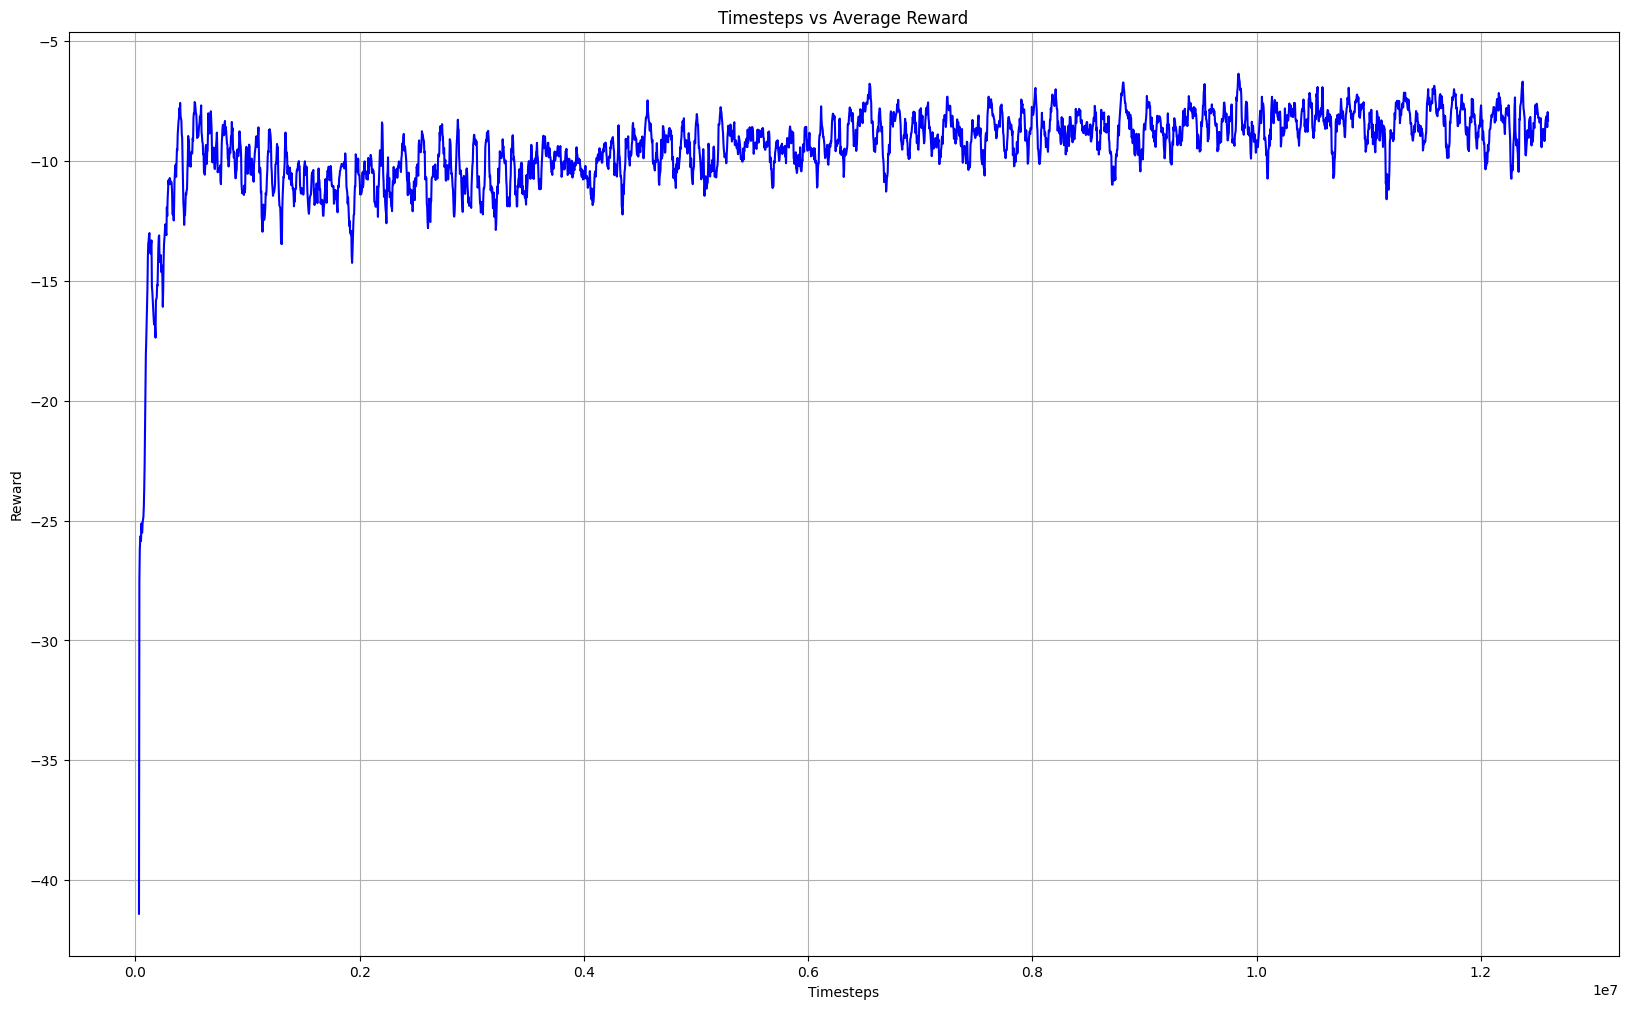

In [8]:


# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV into a DataFrame
csv_file_path = 'C:/Users/Contractor/Workspace/CyMARL/pycomm/results/confidentiality_small_0_2023_12_22_T01_18_07_345992.csv'  # Replace with the actual path to your CSV file
df = pd.read_csv(csv_file_path, skiprows=1)

# Calculate total timesteps for each episode
timesteps_per_episode = 12 * 30
df['T'] = df['episode'] * timesteps_per_episode

# Calculate rolling average of rewards
window_size = 10  # You can adjust this parameter for the desired smoothing effect
df['Mean_Reward'] = df['reward'].rolling(window=window_size).mean()

# Plot episode vs reward
plt.figure(figsize=(20, 12))
plt.plot(df['T'], df['Mean_Reward'], linestyle='-', color='b')
plt.title('Timesteps vs Average Reward')
plt.xlabel('Timesteps')
plt.ylabel('Reward')
plt.grid(True)
plt.show()
